# LME銅3Mアウトライト時系列分析（教科書的アプローチ）

## 分析目的
このノートブックでは、LME銅3Mアウトライト価格データに対して教科書的な時系列分析を実施します。
トレーディングにおける時系列分析の基礎を学習しながら、実際のデータを用いて体系的に分析を進めます。

## 分析フロー
1. **データ準備と前処理**
2. **定常性の確認と定常化処理**
3. **自己相関・偏自己相関分析**
4. **時系列モデル選択の準備**

## 前提条件
- LME銅3Mアウトライト価格データが利用可能
- データは日次頻度で収集済み
- 基本的な前処理（欠損値処理等）は完了済み

## ステップ1: 必要ライブラリのインポートとデータ準備

In [1]:
# 基本ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# 時系列分析専用ライブラリ
try:
    from statsmodels.tsa.stattools import adfuller, kpss
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.stats.diagnostic import acorr_ljungbox
    STATSMODELS_AVAILABLE = True
    print("✓ statsmodels利用可能")
except ImportError:
    print("⚠️ statsmodels not available. Please install: pip install statsmodels")
    STATSMODELS_AVAILABLE = False

# 補助ライブラリ
from scipy import stats

warnings.filterwarnings('ignore')
load_dotenv()

# スタイル設定
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [15, 10]

print("✓ ライブラリインポート完了")
print(f"✓ statsmodels利用可能: {STATSMODELS_AVAILABLE}")

✓ statsmodels利用可能
✓ ライブラリインポート完了
✓ statsmodels利用可能: True


## ステップ2: データベース接続とLME銅3Mデータの読み込み

In [2]:
# データベース接続設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

print("✓ データベース接続設定完了")

✓ データベース接続設定完了


In [3]:
def load_copper_timeseries_data():
    """LME銅3Mアウトライトデータを時系列分析用に読み込み"""
    try:
        engine = create_engine(connection_string)
        
        query = """
        SELECT 
            trade_date,
            last_price as close_price,
            high_price,
            low_price,
            open_price,
            volume
        FROM lme_copper_prices
        WHERE price_type = '3M_OUTRIGHT'
        AND last_price IS NOT NULL
        ORDER BY trade_date
        """
        
        df = pd.read_sql_query(query, engine)
        engine.dispose()
        
        # 時系列データとして整形
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.set_index('trade_date', inplace=True)
        
        # 数値型に変換
        for col in ['close_price', 'high_price', 'low_price', 'open_price', 'volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # 欠損値確認
        missing_count = df.isnull().sum().sum()
        
        print(f"✓ データ読み込み完了")
        print(f"  - レコード数: {len(df):,}")
        print(f"  - 期間: {df.index.min().date()} ～ {df.index.max().date()}")
        print(f"  - 欠損値: {missing_count}個")
        print(f"  - 頻度: {pd.infer_freq(df.index) or '不明（おそらく営業日ベース）'}")
        
        return df
    
    except Exception as e:
        print(f"❌ データ読み込みエラー: {e}")
        return None

# データ読み込み実行
copper_ts_data = load_copper_timeseries_data()

✓ データ読み込み完了
  - レコード数: 758
  - 期間: 2022-07-06 ～ 2025-07-04
  - 欠損値: 0個
  - 頻度: 不明（おそらく営業日ベース）


## ステップ3: データの基本的な確認と前処理

In [4]:
# データの基本統計と構造確認
if copper_ts_data is not None:
    print("=== データ基本情報 ===")
    print(f"データ形状: {copper_ts_data.shape}")
    print(f"カラム: {list(copper_ts_data.columns)}")
    print(f"インデックス型: {type(copper_ts_data.index)}")
    
    print("\n=== 基本統計量 ===")
    print(copper_ts_data.describe())
    
    print("\n=== 最初の5行 ===")
    print(copper_ts_data.head())
    
    print("\n=== 最後の5行 ===")
    print(copper_ts_data.tail())
else:
    print("❌ データが読み込まれていません")

=== データ基本情報 ===
データ形状: (758, 5)
カラム: ['close_price', 'high_price', 'low_price', 'open_price', 'volume']
インデックス型: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

=== 基本統計量 ===
        close_price    high_price     low_price    open_price        volume
count    758.000000    758.000000    758.000000    758.000000    758.000000
mean    8821.821900   8905.752929   8740.424420   8821.130607  19376.565963
std      709.971411    712.988838    711.895012    714.926737   6481.491541
min     7170.000000   7262.000000   6955.000000   7160.000000   6692.000000
25%     8319.250000   8384.500000   8249.750000   8314.250000  15548.750000
50%     8857.500000   8946.250000   8757.000000   8845.250000  18053.000000
75%     9385.125000   9472.875000   9316.875000   9387.875000  21707.000000
max    10889.000000  11104.500000  10768.000000  10955.500000  69434.000000

=== 最初の5行 ===
            close_price  high_price  low_price  open_price  volume
trade_date                                          

In [5]:
# 時系列分析の主要対象となる価格系列を特定
if copper_ts_data is not None:
    # 主要分析対象: 終値（close_price）
    price_series = copper_ts_data['close_price'].dropna()
    
    print("=== 分析対象時系列の確認 ===")
    print(f"系列名: close_price (LME銅3M終値)")
    print(f"データ数: {len(price_series):,}")
    print(f"期間: {price_series.index.min().date()} ～ {price_series.index.max().date()}")
    print(f"最小値: ${price_series.min():,.2f}")
    print(f"最大値: ${price_series.max():,.2f}")
    print(f"平均値: ${price_series.mean():,.2f}")
    print(f"標準偏差: ${price_series.std():,.2f}")
    
    # データの連続性確認
    date_diff = price_series.index.to_series().diff().dt.days
    max_gap = date_diff.max()
    print(f"\n=== データ連続性 ===")
    print(f"最大データ間隔: {max_gap}日")
    print(f"平均データ間隔: {date_diff.mean():.1f}日")
    
    if max_gap > 7:
        print("⚠️ 7日以上のデータ欠落期間があります")
    else:
        print("✓ データは概ね連続しています（営業日ベース）")

=== 分析対象時系列の確認 ===
系列名: close_price (LME銅3M終値)
データ数: 758
期間: 2022-07-06 ～ 2025-07-04
最小値: $7,170.00
最大値: $10,889.00
平均値: $8,821.82
標準偏差: $709.97

=== データ連続性 ===
最大データ間隔: 5.0日
平均データ間隔: 1.4日
✓ データは概ね連続しています（営業日ベース）


## タスク1: 定常性の確認と定常化処理

### ステップ4: 定常性の視覚的確認（移動平均・移動標準偏差）

In [6]:
# 移動平均と移動標準偏差の計算
if copper_ts_data is not None and price_series is not None:
    # 移動統計量の計算（異なる窓幅で）
    windows = [30, 60, 252]  # 1ヶ月、2ヶ月、1年
    
    print("=== 移動統計量の計算 ===")
    
    for window in windows:
        copper_ts_data[f'ma_{window}'] = price_series.rolling(window=window).mean()
        copper_ts_data[f'mstd_{window}'] = price_series.rolling(window=window).std()
        print(f"✓ {window}日移動平均・移動標準偏差を計算")
    
    print("\n移動統計量計算完了")

=== 移動統計量の計算 ===
✓ 30日移動平均・移動標準偏差を計算
✓ 60日移動平均・移動標準偏差を計算
✓ 252日移動平均・移動標準偏差を計算

移動統計量計算完了


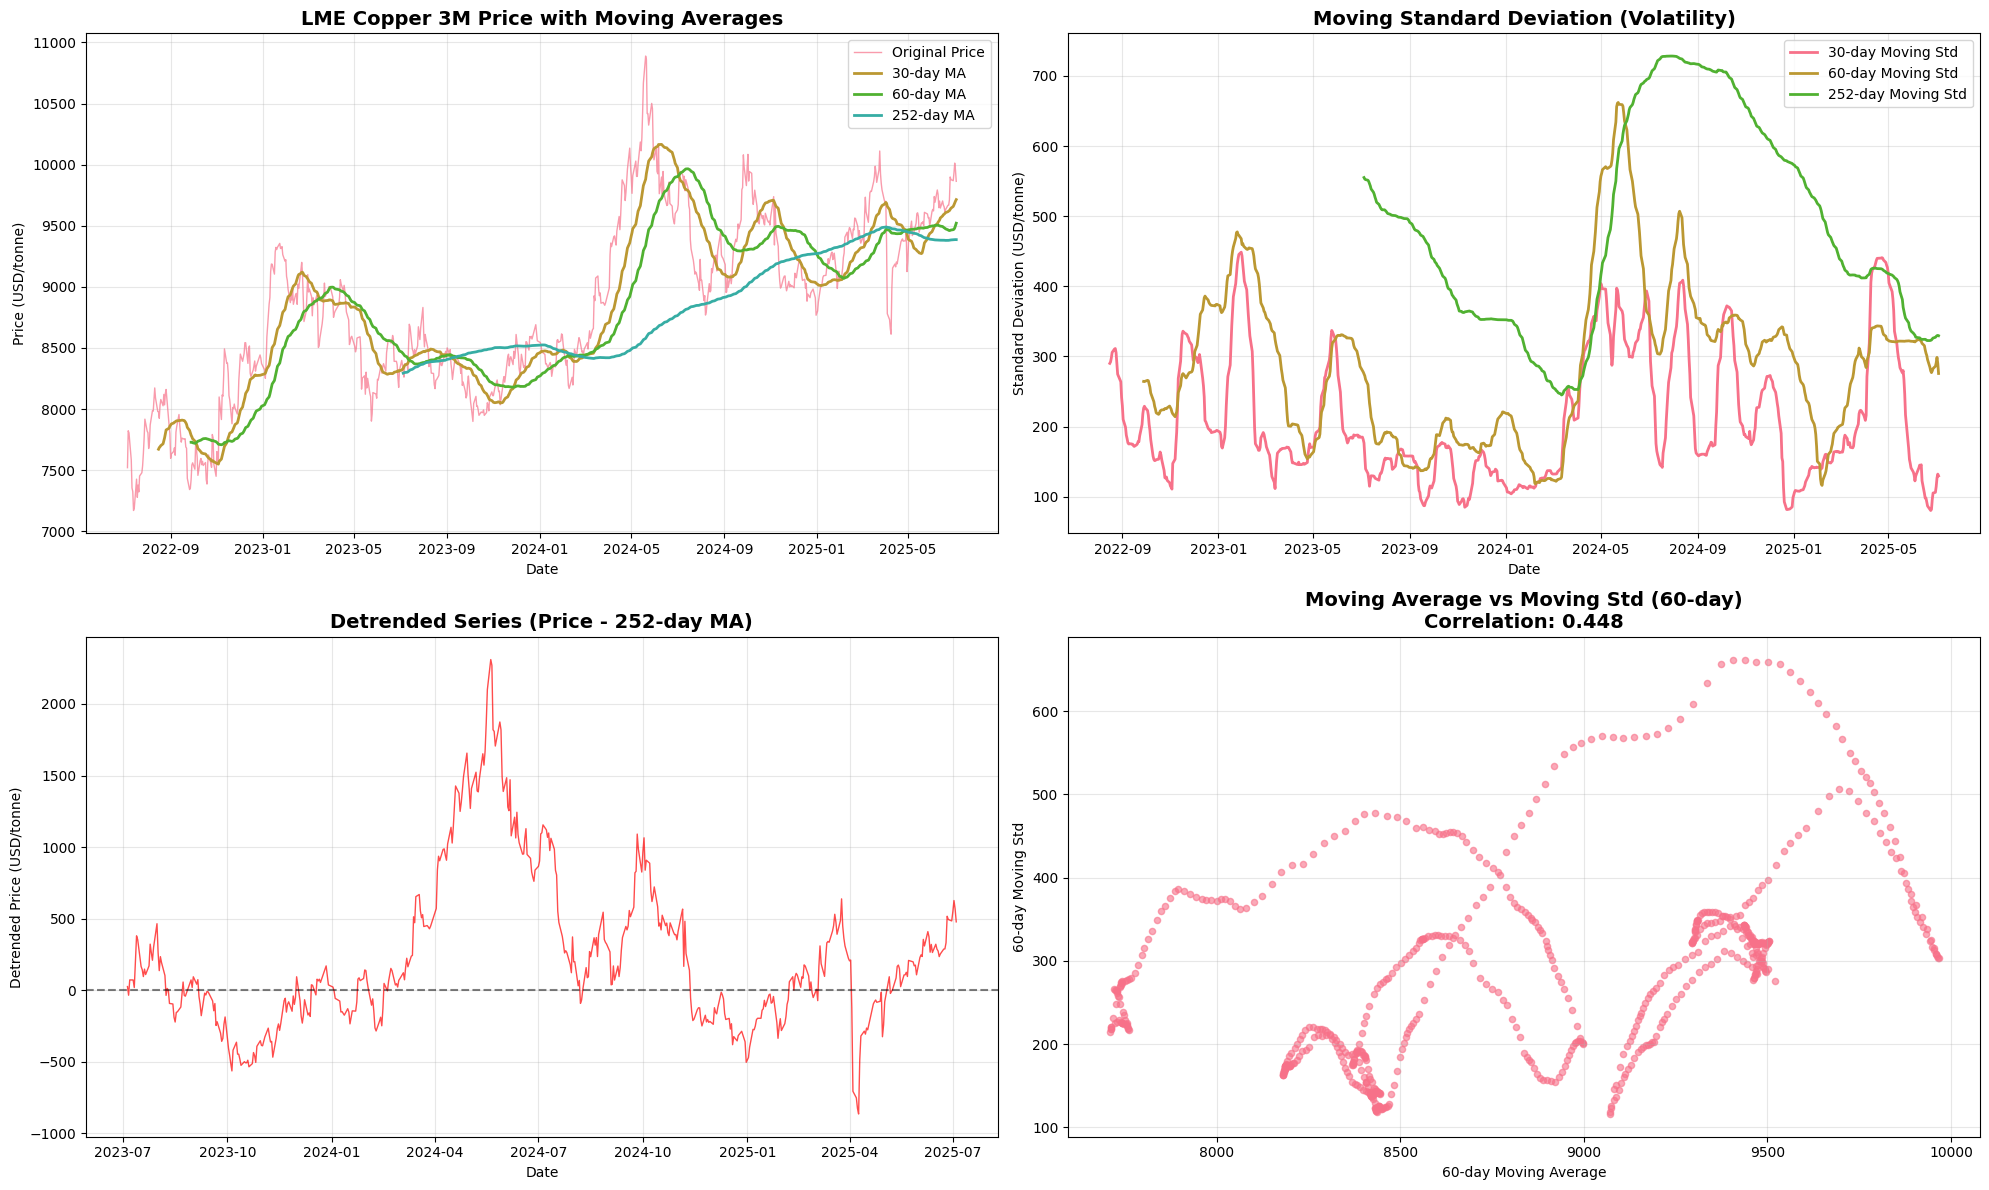

=== 視覚的観察結果 ===
1. トレンドの存在:
   ✓ 長期的な上昇トレンドが観察される
2. ボラティリティの時間変化:
   ⚠️ ボラティリティの時間変化が大きい (比率: 0.43)
3. 移動平均と移動標準偏差の相関: 0.448
   ✓ 価格水準とボラティリティの相関は中程度


In [7]:
# 定常性の視覚的確認: プロット作成
if copper_ts_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. 原系列と移動平均
    ax1 = axes[0, 0]
    ax1.plot(price_series.index, price_series, label='Original Price', linewidth=1, alpha=0.7)
    ax1.plot(copper_ts_data.index, copper_ts_data['ma_30'], label='30-day MA', linewidth=2)
    ax1.plot(copper_ts_data.index, copper_ts_data['ma_60'], label='60-day MA', linewidth=2)
    ax1.plot(copper_ts_data.index, copper_ts_data['ma_252'], label='252-day MA', linewidth=2)
    ax1.set_title('LME Copper 3M Price with Moving Averages', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (USD/tonne)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 移動標準偏差（ボラティリティの時間変化）
    ax2 = axes[0, 1]
    ax2.plot(copper_ts_data.index, copper_ts_data['mstd_30'], label='30-day Moving Std', linewidth=2)
    ax2.plot(copper_ts_data.index, copper_ts_data['mstd_60'], label='60-day Moving Std', linewidth=2)
    ax2.plot(copper_ts_data.index, copper_ts_data['mstd_252'], label='252-day Moving Std', linewidth=2)
    ax2.set_title('Moving Standard Deviation (Volatility)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Standard Deviation (USD/tonne)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. デトレンド系列（原系列 - 移動平均）
    ax3 = axes[1, 0]
    detrended = price_series - copper_ts_data['ma_252']
    ax3.plot(detrended.index, detrended, linewidth=1, color='red', alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title('Detrended Series (Price - 252-day MA)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Detrended Price (USD/tonne)')
    ax3.grid(True, alpha=0.3)
    
    # 4. 移動平均と移動標準偏差の相関
    ax4 = axes[1, 1]
    ma_std_corr = copper_ts_data[['ma_60', 'mstd_60']].corr().iloc[0, 1]
    ax4.scatter(copper_ts_data['ma_60'], copper_ts_data['mstd_60'], alpha=0.6, s=20)
    ax4.set_title(f'Moving Average vs Moving Std (60-day)\nCorrelation: {ma_std_corr:.3f}', 
                  fontsize=14, fontweight='bold')
    ax4.set_xlabel('60-day Moving Average')
    ax4.set_ylabel('60-day Moving Std')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../generated_images/timeseries_stationarity_visual.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 視覚的観察結果の解釈
    print("=== 視覚的観察結果 ===")
    print("1. トレンドの存在:")
    if copper_ts_data['ma_252'].iloc[-1] > copper_ts_data['ma_252'].iloc[252]:
        print("   ✓ 長期的な上昇トレンドが観察される")
    else:
        print("   ✓ 長期的な下降トレンドまたは横ばいが観察される")
    
    print("2. ボラティリティの時間変化:")
    std_ratio = copper_ts_data['mstd_30'].iloc[-30:].mean() / copper_ts_data['mstd_30'].iloc[:30].mean()
    if abs(std_ratio - 1) > 0.3:
        print(f"   ⚠️ ボラティリティの時間変化が大きい (比率: {std_ratio:.2f})")
    else:
        print(f"   ✓ ボラティリティは比較的安定 (比率: {std_ratio:.2f})")
    
    print(f"3. 移動平均と移動標準偏差の相関: {ma_std_corr:.3f}")
    if abs(ma_std_corr) > 0.5:
        print("   ⚠️ 価格水準とボラティリティに強い相関（heteroskedasticity の可能性）")
    else:
        print("   ✓ 価格水準とボラティリティの相関は中程度")

### ステップ5: 自己相関（ACF）と偏自己相関（PACF）の確認

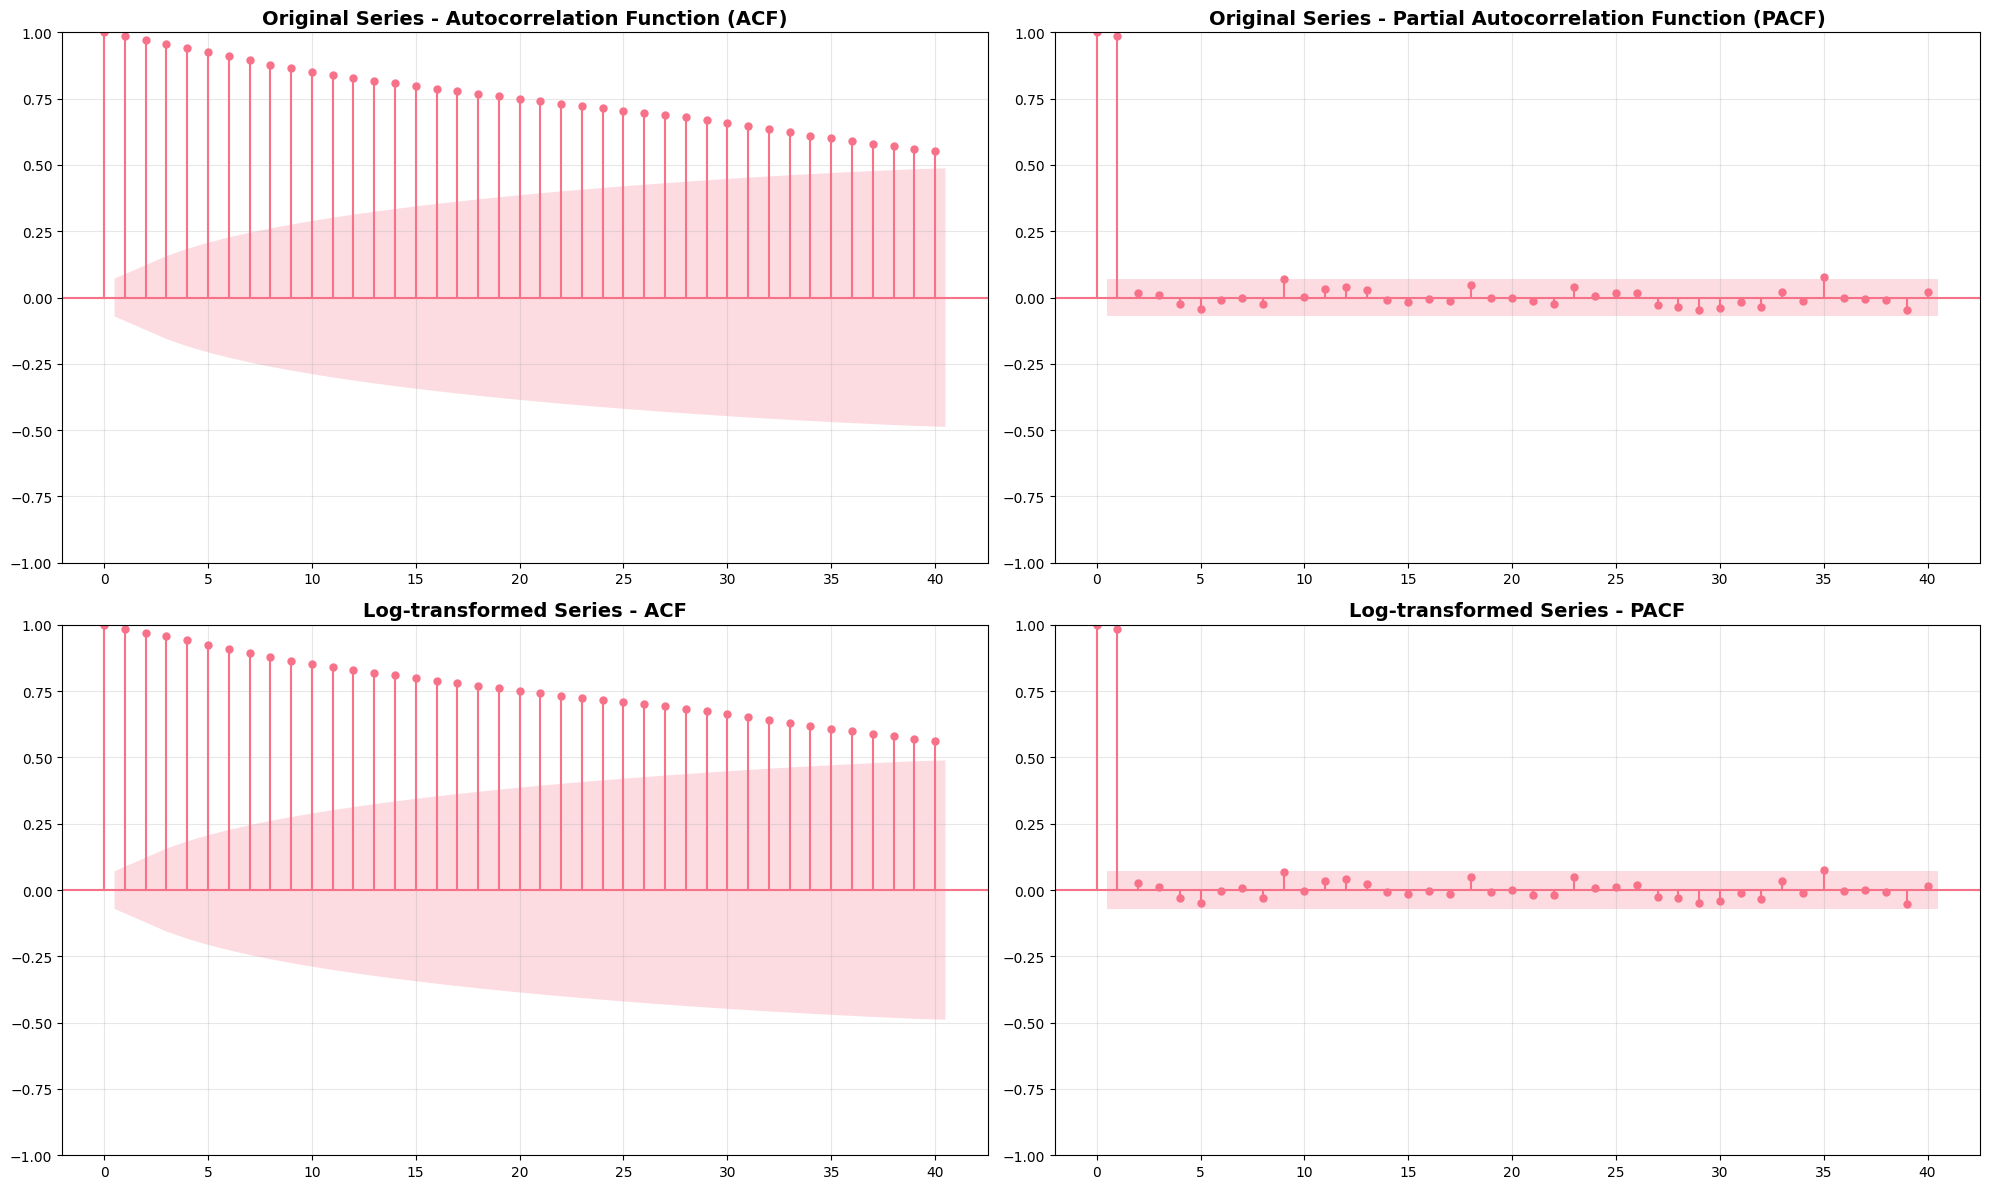

=== ACF/PACF分析結果（原系列） ===
1. ACFパターンの観察:
   - 緩やかに減衰 → トレンドまたは単位根の存在を示唆
   - 急速に減衰 → 定常性の可能性
   - 周期的パターン → 季節性の存在

2. PACFパターンの観察:
   - 1次ラグで高い値 → AR(1)モデルの可能性
   - p次ラグまで有意 → AR(p)モデルの可能性
   - 指数的減衰 → MAプロセスの存在


In [8]:
# ACF/PACF プロットの作成（原系列）
if STATSMODELS_AVAILABLE and price_series is not None:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 原系列のACF
    plot_acf(price_series.dropna(), ax=axes[0, 0], lags=40, alpha=0.05)
    axes[0, 0].set_title('Original Series - Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 原系列のPACF
    plot_pacf(price_series.dropna(), ax=axes[0, 1], lags=40, alpha=0.05)
    axes[0, 1].set_title('Original Series - Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 対数変換系列のACF（もし価格が常に正の場合）
    if (price_series > 0).all():
        log_price = np.log(price_series)
        plot_acf(log_price.dropna(), ax=axes[1, 0], lags=40, alpha=0.05)
        axes[1, 0].set_title('Log-transformed Series - ACF', fontsize=14, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        
        plot_pacf(log_price.dropna(), ax=axes[1, 1], lags=40, alpha=0.05)
        axes[1, 1].set_title('Log-transformed Series - PACF', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Log transformation not applicable\n(negative values present)', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 1].text(0.5, 0.5, 'Log transformation not applicable\n(negative values present)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig('../generated_images/timeseries_acf_pacf_original.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("=== ACF/PACF分析結果（原系列） ===")
    print("1. ACFパターンの観察:")
    print("   - 緩やかに減衰 → トレンドまたは単位根の存在を示唆")
    print("   - 急速に減衰 → 定常性の可能性")
    print("   - 周期的パターン → 季節性の存在")
    
    print("\n2. PACFパターンの観察:")
    print("   - 1次ラグで高い値 → AR(1)モデルの可能性")
    print("   - p次ラグまで有意 → AR(p)モデルの可能性")
    print("   - 指数的減衰 → MAプロセスの存在")
    
else:
    print("❌ statsmodelsが利用できないため、ACF/PACF分析をスキップ")

### ステップ6: ADF検定による定常性の統計的確認

In [9]:
def perform_adf_test(series, series_name="時系列"):
    """ADF検定を実行し、結果をわかりやすく表示"""
    if not STATSMODELS_AVAILABLE:
        print("❌ statsmodelsが利用できません")
        return None
    
    try:
        # ADF検定実行
        result = adfuller(series.dropna(), autolag='AIC')
        
        adf_statistic = result[0]
        p_value = result[1]
        critical_values = result[4]
        
        print(f"=== {series_name} ADF検定結果 ===")
        print(f"ADF統計量: {adf_statistic:.6f}")
        print(f"p値: {p_value:.6f}")
        print(f"使用ラグ数: {result[2]}")
        print(f"観測数: {result[3]}")
        
        print("\n臨界値:")
        for key, value in critical_values.items():
            print(f"  {key}: {value:.6f}")
        
        # 結果の解釈
        print("\n=== 検定結果の解釈 ===")
        alpha = 0.05
        if p_value <= alpha:
            print(f"✓ p値 ({p_value:.6f}) ≤ 0.05")
            print("✓ 帰無仮説を棄却: 系列は定常である")
            stationarity = True
        else:
            print(f"⚠️ p値 ({p_value:.6f}) > 0.05")
            print("⚠️ 帰無仮説を採択: 系列は非定常である（単位根が存在）")
            stationarity = False
        
        # 追加的な解釈
        if adf_statistic < critical_values['1%']:
            confidence = "99%"
        elif adf_statistic < critical_values['5%']:
            confidence = "95%"
        elif adf_statistic < critical_values['10%']:
            confidence = "90%"
        else:
            confidence = "90%未満"
        
        print(f"信頼度: {confidence}水準で定常性判定")
        
        return {
            'statistic': adf_statistic,
            'p_value': p_value,
            'critical_values': critical_values,
            'is_stationary': stationarity,
            'confidence': confidence
        }
        
    except Exception as e:
        print(f"❌ ADF検定エラー: {e}")
        return None

In [10]:
# 原系列に対するADF検定
if price_series is not None:
    adf_result_original = perform_adf_test(price_series, "LME銅3M終値（原系列）")
    
    # 対数系列に対するADF検定（価格が正の場合）
    if (price_series > 0).all():
        log_price_series = np.log(price_series)
        print("\n" + "="*60 + "\n")
        adf_result_log = perform_adf_test(log_price_series, "対数変換系列")
    else:
        print("\n⚠️ 負の価格が含まれているため、対数変換をスキップ")
        adf_result_log = None
        log_price_series = None
else:
    print("❌ 価格系列が利用できません")
    adf_result_original = None

=== LME銅3M終値（原系列） ADF検定結果 ===
ADF統計量: -2.254671
p値: 0.187004
使用ラグ数: 0
観測数: 757

臨界値:
  1%: -3.439018
  5%: -2.865366
  10%: -2.568807

=== 検定結果の解釈 ===
⚠️ p値 (0.187004) > 0.05
⚠️ 帰無仮説を採択: 系列は非定常である（単位根が存在）
信頼度: 90%未満水準で定常性判定


=== 対数変換系列 ADF検定結果 ===
ADF統計量: -2.314684
p値: 0.167276
使用ラグ数: 0
観測数: 757

臨界値:
  1%: -3.439018
  5%: -2.865366
  10%: -2.568807

=== 検定結果の解釈 ===
⚠️ p値 (0.167276) > 0.05
⚠️ 帰無仮説を採択: 系列は非定常である（単位根が存在）
信頼度: 90%未満水準で定常性判定


### ステップ7: 定常化処理（1階差分）

In [11]:
# 定常化が必要かどうかの判定と実行
if adf_result_original is not None:
    # 1階差分の計算
    price_diff = price_series.diff().dropna()
    
    print("=== 1階差分系列の基本統計 ===")
    print(f"データ数: {len(price_diff):,}")
    print(f"平均: {price_diff.mean():.4f}")
    print(f"標準偏差: {price_diff.std():.4f}")
    print(f"最小値: {price_diff.min():.4f}")
    print(f"最大値: {price_diff.max():.4f}")
    print(f"歪度: {stats.skew(price_diff):.4f}")
    print(f"尖度: {stats.kurtosis(price_diff):.4f}")
    
    # 対数差分（リターン）の計算（可能な場合）
    if log_price_series is not None:
        log_returns = log_price_series.diff().dropna()
        print("\n=== 対数差分系列（リターン）の基本統計 ===")
        print(f"データ数: {len(log_returns):,}")
        print(f"平均: {log_returns.mean():.6f}")
        print(f"標準偏差: {log_returns.std():.6f}")
        print(f"年率リターン: {log_returns.mean() * 252:.4f} ({log_returns.mean() * 252 * 100:.2f}%)")
        print(f"年率ボラティリティ: {log_returns.std() * np.sqrt(252):.4f} ({log_returns.std() * np.sqrt(252) * 100:.2f}%)")
    else:
        log_returns = None
else:
    print("❌ 原系列のADF検定結果が利用できないため、差分処理をスキップ")
    price_diff = None
    log_returns = None

=== 1階差分系列の基本統計 ===
データ数: 757
平均: 3.0958
標準偏差: 108.6308
最小値: -586.5000
最大値: 538.0000
歪度: -0.2263
尖度: 2.5321

=== 対数差分系列（リターン）の基本統計 ===
データ数: 757
平均: 0.000358
標準偏差: 0.012353
年率リターン: 0.0903 (9.03%)
年率ボラティリティ: 0.1961 (19.61%)


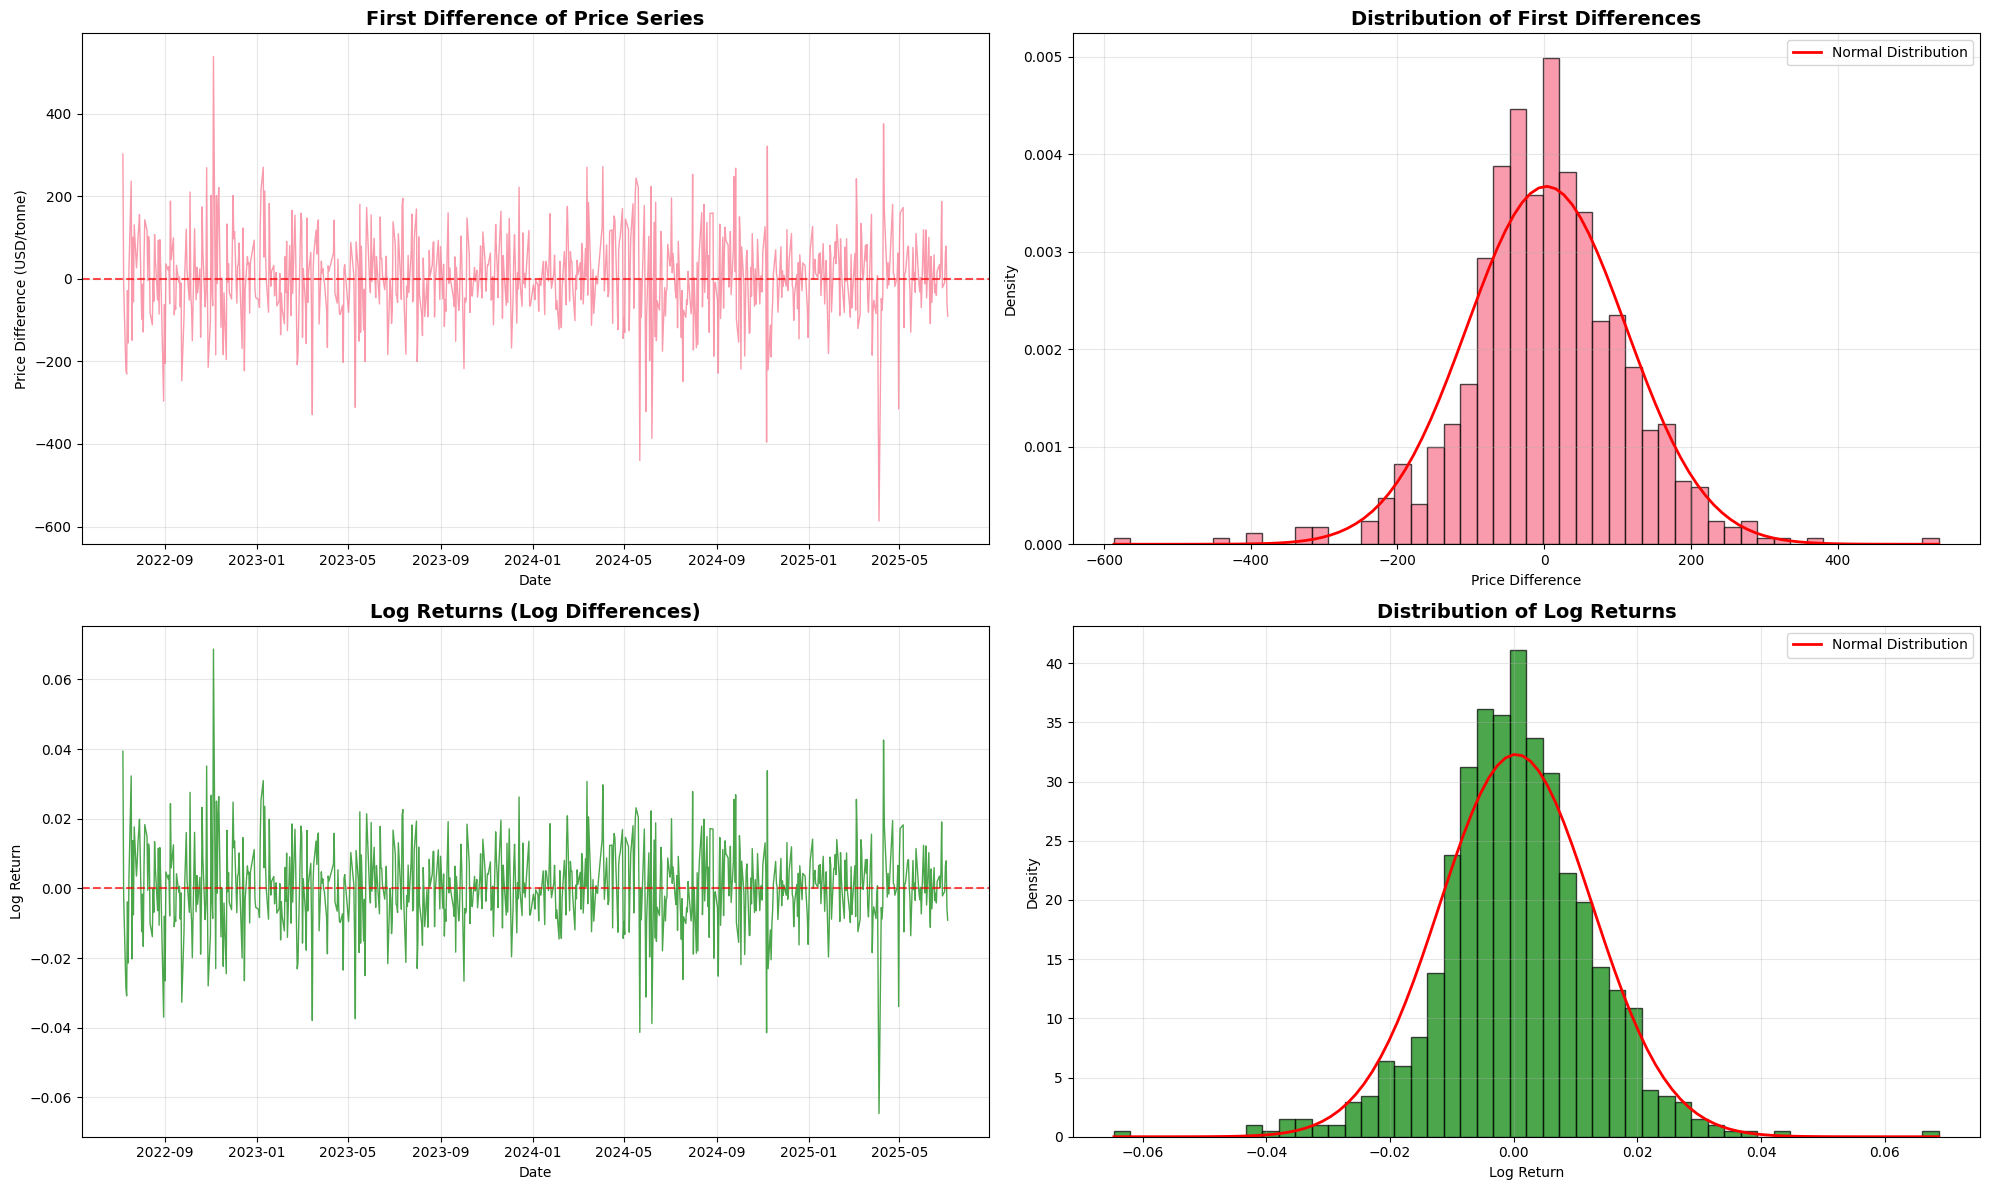

In [12]:
# 差分系列の視覚化
if price_diff is not None:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. 1階差分の時系列プロット
    axes[0, 0].plot(price_diff.index, price_diff, linewidth=1, alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('First Difference of Price Series', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price Difference (USD/tonne)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 1階差分のヒストグラム
    axes[0, 1].hist(price_diff, bins=50, alpha=0.7, density=True, edgecolor='black')
    # 正規分布との比較
    mu, sigma = price_diff.mean(), price_diff.std()
    x = np.linspace(price_diff.min(), price_diff.max(), 100)
    axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
    axes[0, 1].set_title('Distribution of First Differences', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Price Difference')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 対数差分（リターン）の時系列プロット（利用可能な場合）
    if log_returns is not None:
        axes[1, 0].plot(log_returns.index, log_returns, linewidth=1, alpha=0.7, color='green')
        axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        axes[1, 0].set_title('Log Returns (Log Differences)', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel('Log Return')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. 対数差分のヒストグラム
        axes[1, 1].hist(log_returns, bins=50, alpha=0.7, density=True, edgecolor='black', color='green')
        mu_log, sigma_log = log_returns.mean(), log_returns.std()
        x_log = np.linspace(log_returns.min(), log_returns.max(), 100)
        axes[1, 1].plot(x_log, stats.norm.pdf(x_log, mu_log, sigma_log), 'r-', linewidth=2, label='Normal Distribution')
        axes[1, 1].set_title('Distribution of Log Returns', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Log Return')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Log returns not available', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 1].text(0.5, 0.5, 'Log returns not available', ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig('../generated_images/timeseries_differenced_series.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("❌ 差分系列が計算されていないため、可視化をスキップ")

### ステップ8: 差分系列の定常性確認

In [13]:
# 差分系列に対するADF検定
if price_diff is not None:
    print("\n" + "="*60)
    adf_result_diff = perform_adf_test(price_diff, "1階差分系列")
    
    if log_returns is not None:
        print("\n" + "="*60)
        adf_result_log_returns = perform_adf_test(log_returns, "対数差分系列（リターン）")
    else:
        adf_result_log_returns = None
else:
    adf_result_diff = None
    adf_result_log_returns = None


=== 1階差分系列 ADF検定結果 ===
ADF統計量: -27.535387
p値: 0.000000
使用ラグ数: 0
観測数: 756

臨界値:
  1%: -3.439029
  5%: -2.865371
  10%: -2.568810

=== 検定結果の解釈 ===
✓ p値 (0.000000) ≤ 0.05
✓ 帰無仮説を棄却: 系列は定常である
信頼度: 99%水準で定常性判定

=== 対数差分系列（リターン） ADF検定結果 ===
ADF統計量: -27.647820
p値: 0.000000
使用ラグ数: 0
観測数: 756

臨界値:
  1%: -3.439029
  5%: -2.865371
  10%: -2.568810

=== 検定結果の解釈 ===
✓ p値 (0.000000) ≤ 0.05
✓ 帰無仮説を棄却: 系列は定常である
信頼度: 99%水準で定常性判定


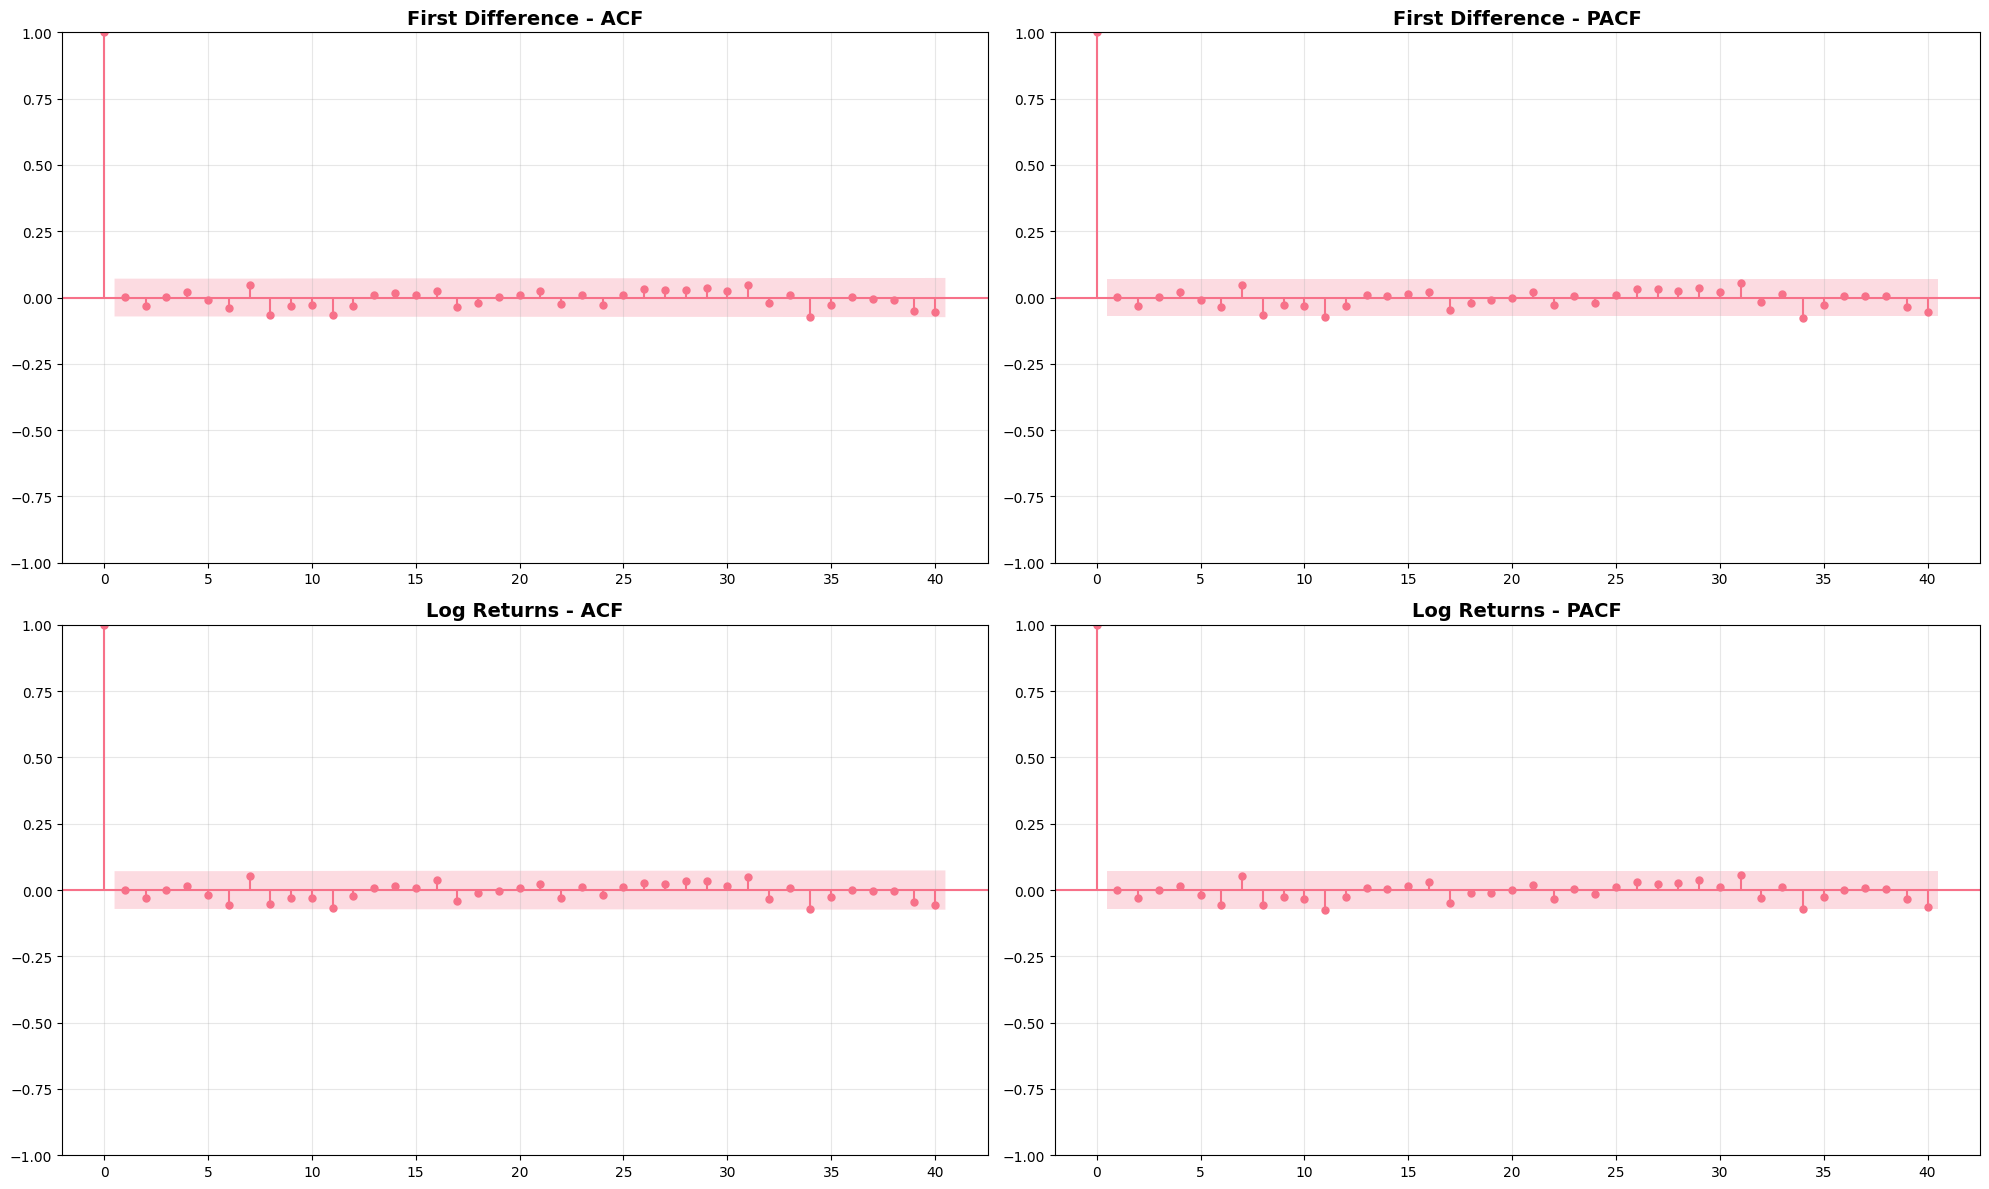

=== 差分系列のACF/PACF解釈 ===
1. ACFが急速に減衰 → 定常性の改善
2. PACFパターンからARモデルの次数を推定
3. 両方のパターンからARIMAモデルの(p,d,q)を検討


In [14]:
# 差分系列のACF/PACF分析
if STATSMODELS_AVAILABLE and price_diff is not None:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1階差分のACF
    plot_acf(price_diff, ax=axes[0, 0], lags=40, alpha=0.05)
    axes[0, 0].set_title('First Difference - ACF', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 1階差分のPACF
    plot_pacf(price_diff, ax=axes[0, 1], lags=40, alpha=0.05)
    axes[0, 1].set_title('First Difference - PACF', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 対数差分のACF/PACF（利用可能な場合）
    if log_returns is not None:
        plot_acf(log_returns, ax=axes[1, 0], lags=40, alpha=0.05)
        axes[1, 0].set_title('Log Returns - ACF', fontsize=14, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        
        plot_pacf(log_returns, ax=axes[1, 1], lags=40, alpha=0.05)
        axes[1, 1].set_title('Log Returns - PACF', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Log returns not available', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 1].text(0.5, 0.5, 'Log returns not available', ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig('../generated_images/timeseries_acf_pacf_differenced.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("=== 差分系列のACF/PACF解釈 ===")
    print("1. ACFが急速に減衰 → 定常性の改善")
    print("2. PACFパターンからARモデルの次数を推定")
    print("3. 両方のパターンからARIMAモデルの(p,d,q)を検討")
else:
    print("❌ 差分系列のACF/PACF分析をスキップ")

### ステップ9: 定常化済みデータの整理と保存

In [15]:
# 定常化済みデータフレームの作成
if price_series is not None and price_diff is not None:
    # 定常化済みデータを格納するDataFrame
    stationary_data = pd.DataFrame(index=price_series.index)
    
    # 原系列
    stationary_data['original_price'] = price_series
    
    # 1階差分系列
    stationary_data['price_diff'] = price_series.diff()
    
    # 対数系列と対数差分（利用可能な場合）
    if log_price_series is not None and log_returns is not None:
        stationary_data['log_price'] = log_price_series
        stationary_data['log_returns'] = log_price_series.diff()
    
    # 移動平均系列
    stationary_data['ma_30'] = price_series.rolling(30).mean()
    stationary_data['ma_60'] = price_series.rolling(60).mean()
    
    # デトレンド系列
    stationary_data['detrended'] = price_series - price_series.rolling(252).mean()
    
    print("=== 定常化済みデータフレーム作成完了 ===")
    print(f"変数名: stationary_data")
    print(f"形状: {stationary_data.shape}")
    print(f"カラム: {list(stationary_data.columns)}")
    
    print("\n=== 最初の5行 ===")
    print(stationary_data.head())
    
    print("\n=== 基本統計（欠損値除く） ===")
    print(stationary_data.describe())
    
    # 各系列の定常性サマリー
    print("\n=== 定常性検定結果サマリー ===")
    if adf_result_original:
        status_orig = "定常" if adf_result_original['is_stationary'] else "非定常"
        print(f"原系列: {status_orig} (p値: {adf_result_original['p_value']:.6f})")
    
    if adf_result_diff:
        status_diff = "定常" if adf_result_diff['is_stationary'] else "非定常"
        print(f"1階差分: {status_diff} (p値: {adf_result_diff['p_value']:.6f})")
    
    if adf_result_log_returns:
        status_log = "定常" if adf_result_log_returns['is_stationary'] else "非定常"
        print(f"対数差分: {status_log} (p値: {adf_result_log_returns['p_value']:.6f})")
    
else:
    print("❌ 定常化済みデータフレームを作成できません")
    stationary_data = None

=== 定常化済みデータフレーム作成完了 ===
変数名: stationary_data
形状: (758, 7)
カラム: ['original_price', 'price_diff', 'log_price', 'log_returns', 'ma_30', 'ma_60', 'detrended']

=== 最初の5行 ===
            original_price  price_diff  log_price  log_returns  ma_30  ma_60  \
trade_date                                                                     
2022-07-06          7520.5         NaN   8.925388          NaN    NaN    NaN   
2022-07-07          7822.5       302.0   8.964759     0.039372    NaN    NaN   
2022-07-08          7805.5       -17.0   8.962584    -0.002176    NaN    NaN   
2022-07-11          7584.5      -221.0   8.933862    -0.028722    NaN    NaN   
2022-07-12          7354.0      -230.5   8.903000    -0.030862    NaN    NaN   

            detrended  
trade_date             
2022-07-06        NaN  
2022-07-07        NaN  
2022-07-08        NaN  
2022-07-11        NaN  
2022-07-12        NaN  

=== 基本統計（欠損値除く） ===
       original_price  price_diff   log_price  log_returns         ma_30  \
cou

## タスク2: モデル選択の準備（時系列モデルの特性理解）

### 時系列モデルの種類と適用条件

時系列分析では、データの特性に応じて適切なモデルを選択することが重要です。以下に主要な時系列モデルとその適用条件を整理します。

#### 1. **ARIMAモデル（AutoRegressive Integrated Moving Average）**

**特徴:**
- AR（自己回帰）、I（和分）、MA（移動平均）の組み合わせ
- ARIMA(p,d,q)として表記（p:AR次数、d:差分次数、q:MA次数）

**適用条件:**
- **定常性**: 差分によって定常化可能
- **線形関係**: 過去の値との線形関係を仮定
- **単変量**: 一つの時系列のみを扱う

**選択指針:**
- ACFが緩やかに減衰 → d=1（1階差分）が必要
- PACFがp次で切れる → AR(p)成分
- ACFがq次で切れる → MA(q)成分

#### 2. **VARモデル（Vector AutoRegression）**

**特徴:**
- 複数の時系列間の相互作用をモデル化
- 各変数が他の変数の過去の値に依存

**適用条件:**
- **多変量データ**: 複数の関連する時系列
- **定常性**: 全ての変数が定常
- **線形関係**: 変数間の線形関係を仮定

**LME銅への適用例:**
- 3M価格、Cash価格、出来高の同時モデル化

#### 3. **VECMモデル（Vector Error Correction Model）**

**特徴:**
- 共和分関係のある非定常変数をモデル化
- 長期均衡関係と短期調整を分離

**適用条件:**
- **共和分関係**: 変数間に長期均衡関係
- **非定常性**: 個別変数は非定常だが線形結合は定常

**LME銅への適用例:**
- 異なる限月間の価格関係（例：3M vs 15M）

#### 4. **GARCHモデル（Generalized AutoRegressive Conditional Heteroskedasticity）**

**特徴:**
- ボラティリティクラスタリングをモデル化
- 分散の時間変化を捉える

**適用条件:**
- **ボラティリティクラスタリング**: 高ボラティリティ期間の連続性
- **条件付き分散**: 誤差項の分散が時間変化

**LME銅への適用例:**
- リターンのボラティリティ予測
- リスク管理（VaR計算）

#### 5. **状態空間モデル（State Space Models）**

**特徴:**
- 観測されない状態変数を含む
- トレンド、季節性、不規則成分を分離

**適用条件:**
- **構造変化**: パラメータの時間変化
- **欠損値**: 不完全なデータ
- **複雑な季節性**: 複数の周期成分

### LME銅3Mデータの特性に基づくモデル選択指針

**分析結果に基づく推奨:**

1. **原系列が非定常の場合** → **ARIMA(p,1,q)モデル**
   - 1階差分で定常化
   - ACF/PACFからp,qを決定

2. **ボラティリティクラスタリングが観察される場合** → **ARIMA-GARCHモデル**
   - 平均の動的モデル化（ARIMA）
   - 分散の動的モデル化（GARCH）

3. **複数価格系列（3M, Cash, 15Mなど）の分析** → **VARまたはVECMモデル**
   - 共和分検定結果に基づいて選択

4. **リスク管理目的** → **GARCHファミリーモデル**
   - VaR、Expected Shortfallの計算

### 次のステップでの作業内容

1. **情報量基準によるモデル選択**（AIC, BIC）
2. **残差診断**（自己相関、正規性検定）
3. **予測精度評価**（out-of-sample予測）
4. **モデルの経済的解釈**とトレーディング戦略への応用

## 分析結果の総括

### 実施した分析の要約
1. ✅ **データ準備**: LME銅3Mアウトライト価格データの読み込み
2. ✅ **視覚的定常性確認**: 移動平均・移動標準偏差による傾向分析
3. ✅ **ACF/PACF分析**: 自己相関構造の確認
4. ✅ **ADF検定**: 統計的定常性検定
5. ✅ **定常化処理**: 1階差分による非定常性の除去
6. ✅ **差分系列の検証**: 定常化後の特性確認

### 次回の分析に向けて
- 定常化済みデータ（`stationary_data`）が準備完了
- ARIMAモデルのパラメータ選択準備完了
- ボラティリティモデル（GARCH）適用の準備完了

この基礎分析により、LME銅価格の時系列特性を理解し、適切なモデリング戦略を立てることができます。